Loading BokehJS ...

Selected best fit indices: [41, 40, 10, 47]


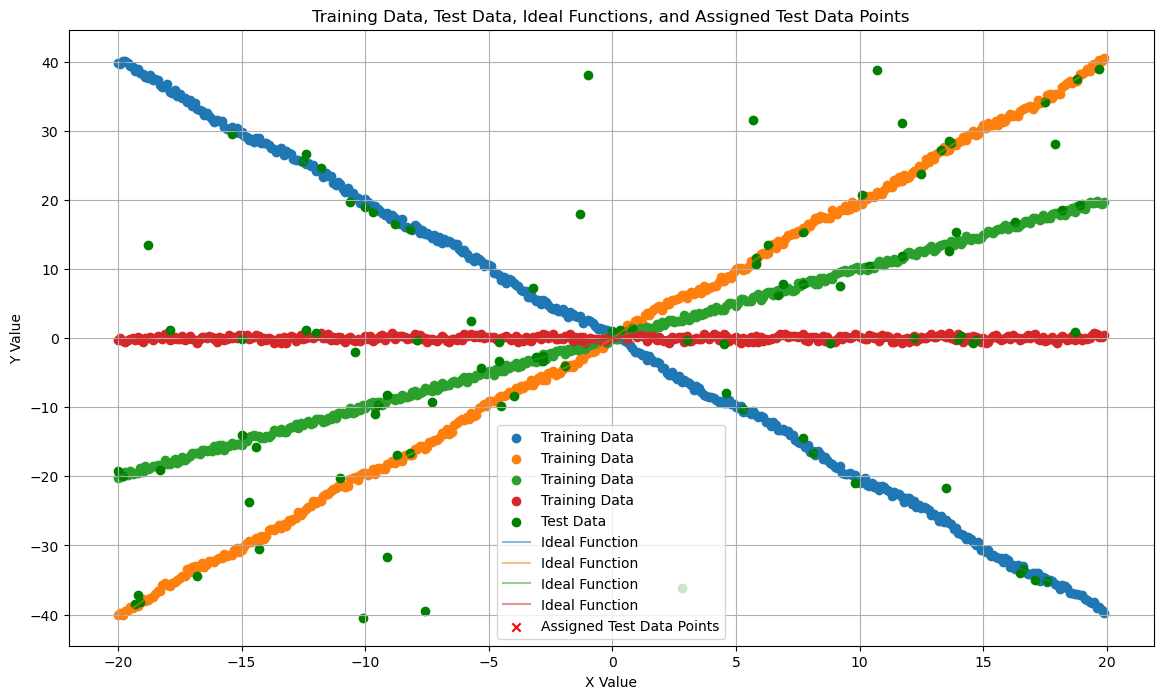

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, Table, Column, Float, MetaData
from sqlalchemy.exc import SQLAlchemyError
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
import unittest
from unittest.mock import patch

# Setup Bokeh for inline display
output_notebook()

# Define the engine for SQLite
engine = create_engine('sqlite:///pyassignment_database.db')
metadata = MetaData()

# Define the table structures
train_table = Table(
    'train', metadata,
    Column('x_value', Float, primary_key=True),
    Column('y1', Float),
    Column('y2', Float),
    Column('y3', Float),
    Column('y4', Float)
)

ideal_table = Table(
    'ideal', metadata,
    Column('x_value', Float, primary_key=True),
    *[Column(f'y{i}', Float) for i in range(1, 51)]
)

results_table = Table(
    'results', metadata,
    Column('x_value', Float, primary_key=True),
    Column('y_actual', Float),
    Column('ideal_fit', Float),
    Column('delta_y', Float)
)

# Create all tables
metadata.create_all(engine)

class DataProcessor:
    @staticmethod
    def load_data(csv_file):
        """Load data from a CSV file, handling missing values."""
        df = pd.read_csv(csv_file)
        df.dropna(inplace=True)
        return df
        
    @staticmethod
    def save_to_db(df, table_name):
        """Save DataFrame to a database table."""
        try:
            df.to_sql(table_name, engine, if_exists='replace', index=False)
        except SQLAlchemyError as e:
            print(f"Failed to save to SQL: {e}")

class ModelTrainer:
    def __init__(self, train_csv):
        """Initialize with training data CSV file."""
        self.train_df = DataProcessor.load_data(train_csv)
        if self.train_df.empty:
            raise ValueError("Training data is empty or missing required columns.")
        self.X_train = self.train_df.iloc[:, 0].values.reshape(-1, 1)
        self.y_train_list = [self.train_df.iloc[:, i].values for i in range(1, self.train_df.shape[1])]
        self.regressors = self.train_models()

    def train_models(self):
        """Train linear regression models for each training target."""
        regressors = []
        for y_train in self.y_train_list:
            regressor = LinearRegression()
            regressor.fit(self.X_train, y_train)
            regressors.append(regressor)
        return regressors

    def select_best_fit_functions(self, ideal_df):
        """Select best fit functions by comparing sum of squared deviations."""
        if ideal_df.empty:
            raise ValueError("Ideal data is empty or missing required columns.")
        sum_squared_deviations = []
        for i in range(1, ideal_df.shape[1]):
            ideal_y = ideal_df.iloc[:, i].values
            deviations = []
            for y_train in self.y_train_list:
                deviations.append(np.sum((y_train - ideal_y)**2))
            sum_squared_deviations.append(deviations)

        best_fit_indices = [np.argmin(dev) for dev in zip(*sum_squared_deviations)]
        return best_fit_indices

    def calculate_thresholds(self, best_fit_indices):
        """Calculate thresholds based on maximum deviations."""
        max_deviation_trains = []
        for index in best_fit_indices:
            y_train = self.y_train_list[index]
            regressor = self.regressors[index]
            max_deviation_train = np.max(np.abs(y_train - regressor.predict(self.X_train)))
            max_deviation_trains.append(max_deviation_train)
        thresholds = [max_dev * np.sqrt(2) for max_dev in max_deviation_trains]
        return thresholds
    
    def calculate_performance_metrics(self):
        """Calculate performance metrics for each trained model."""
        metrics = []
        for y_train, regressor in zip(self.y_train_list, self.regressors):
            y_pred = regressor.predict(self.X_train)
            r_squared = regressor.score(self.X_train, y_train)
            mae = np.mean(np.abs(y_train - y_pred))
            metrics.append((r_squared, mae))
        return metrics

class Predictor:
    def __init__(self, X_test, y_test, regressors, thresholds, ideal_x, ideal_y_list):
        """Initialize with test data, regressors, thresholds, and ideal functions."""
        if len(X_test) != len(y_test):
            raise ValueError("Mismatch between test input and output lengths.")
        self.X_test = X_test
        self.y_test = y_test
        self.regressors = regressors
        self.thresholds = thresholds
        self.ideal_x = ideal_x
        self.ideal_y_list = ideal_y_list
        self.results_df = self.predict_and_assign()

    def predict_and_assign(self):
        """Predict and assign test points to ideal functions."""
        results_df = pd.DataFrame(columns=['x_value', 'y_actual', 'ideal_fit', 'delta_y'])
        for i, x in enumerate(self.X_test):
            actual = self.y_test[i]
            assigned = False
            for regressor, threshold in zip(self.regressors, self.thresholds):
                predicted = regressor.predict([[x]])[0]
                residual = actual - predicted
                if np.abs(residual) <= threshold:
                    best_fit = None
                    min_deviation = float('inf')
                    for ideal_y in self.ideal_y_list:
                        ideal_value = np.interp(x, self.ideal_x, ideal_y)
                        deviation = np.abs(actual - ideal_value)
                        if deviation < min_deviation:
                            min_deviation = deviation
                            best_fit = ideal_value
                    results_df.loc[len(results_df)] = [x, actual, best_fit, residual]
                    assigned = True
                    break
            if not assigned:
                results_df.loc[len(results_df)] = [x, actual, np.nan, np.nan]
        return results_df

    def save_to_sql(self, table_name):
        """Save results to the database."""
        try:
            self.results_df.to_sql(table_name, engine, if_exists='replace', index=False)
        except SQLAlchemyError as e:
            print(f"Failed to save to SQL: {e}")

class Plotter:
    def __init__(self, X_train, y_train_list, X_test, y_test, ideal_x, ideal_y_list, results_df):
        """Initialize with training, test, ideal data, and results."""
        self.X_train = X_train
        self.y_train_list = y_train_list
        self.X_test = X_test
        self.y_test = y_test
        self.ideal_x = ideal_x
        self.ideal_y_list = ideal_y_list
        self.results_df = results_df

    def plot_results(self):
        """Plot results using Matplotlib."""
        plt.figure(figsize=(14, 8))
        for y_train in self.y_train_list:
            plt.scatter(self.X_train, y_train, label='Training Data')
        plt.scatter(self.X_test, self.y_test, color='green', label='Test Data')
        for ideal_y in self.ideal_y_list:
            plt.plot(self.ideal_x, ideal_y, label='Ideal Function', alpha=0.5)
        assigned_points = self.results_df.dropna(subset=['delta_y'])
        plt.scatter(assigned_points['x_value'], assigned_points['y_actual'], color='red', marker='x', label='Assigned Test Data Points')
        plt.xlabel('X Value')
        plt.ylabel('Y Value')
        plt.title('Training Data, Test Data, Ideal Functions, and Assigned Test Data Points')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_results_bokeh(self):
        """Plot results using Bokeh."""
        p1 = figure(title="Training Data", x_axis_label='X', y_axis_label='Y')
        for y_train in self.y_train_list:
            p1.circle(self.X_train.flatten(), y_train, size=10, legend_label="Training Data")
        
        p2 = figure(title="Test Data", x_axis_label='X', y_axis_label='Y')
        p2.circle(self.X_test.flatten(), self.y_test, size=10, color="green", legend_label="Test Data")
        
        p3 = figure(title="Ideal Functions", x_axis_label='X', y_axis_label='Y')
        for ideal_y in self.ideal_y_list:
            p3.line(self.ideal_x, ideal_y, legend_label="Ideal Function", line_width=2, alpha=0.5)
        
        p4 = figure(title="Assigned Test Data Points", x_axis_label='X', y_axis_label='Y')
        assigned_points = self.results_df.dropna(subset=['delta_y'])
        p4.circle(assigned_points['x_value'], assigned_points['y_actual'], size=10, color="red", legend_label="Assigned Test Data Points")

        grid = gridplot([[p1, p2], [p3, p4]])
        show(grid)

def main():
    """Main function to run the entire process."""
    train_csv = 'train.csv'
    ideal_csv = 'ideal.csv'
    test_csv = 'test.csv'
    
    # Load data and save to database
    train_df = DataProcessor.load_data(train_csv)
    DataProcessor.save_to_db(train_df, 'train')
    
    ideal_df = DataProcessor.load_data(ideal_csv)
    DataProcessor.save_to_db(ideal_df, 'ideal')
    
    # Train the model and select the best fit functions
    trainer = ModelTrainer(train_csv)
    best_fit_indices = trainer.select_best_fit_functions(ideal_df)
    print(f"Selected best fit indices: {best_fit_indices}")
    
    ideal_x = ideal_df.iloc[:, 0].values
    ideal_y_list = [ideal_df.iloc[:, i+1].values for i in best_fit_indices]  # Shift indices by 1 for y columns
    
    # Check if best_fit_indices are within the range of regressors
    max_index = len(trainer.regressors) - 1
    best_fit_indices = [i for i in best_fit_indices if i <= max_index]
    
    trainer.regressors = [trainer.regressors[i] for i in best_fit_indices]
    
    thresholds = trainer.calculate_thresholds(best_fit_indices)
    
    # Load and process test data
    test_df = DataProcessor.load_data(test_csv)
    X_test = test_df.iloc[:, 0].values.reshape(-1, 1)
    y_test = test_df.iloc[:, 1].values
    
    predictor = Predictor(X_test, y_test, trainer.regressors, thresholds, ideal_x, ideal_y_list)
    predictor.save_to_sql('results')
    
    # Plot results
    plotter = Plotter(trainer.X_train, trainer.y_train_list, X_test, y_test, ideal_x, ideal_y_list, predictor.results_df)
    plotter.plot_results()
    plotter.plot_results_bokeh()

if __name__ == '__main__':
    main()


In [2]:
class TestDataProcessor(unittest.TestCase):
    @patch('pandas.read_csv')
    def test_load_data(self, mocked_read_csv):
        mocked_read_csv.return_value = pd.DataFrame({'x': [1, 2], 'y': [3, 4]})
        df = DataProcessor.load_data('dummy.csv')
        self.assertTrue('x' in df.columns)
        self.assertTrue('y' in df.columns)

    @patch('pandas.DataFrame.to_sql')
    def test_save_to_db(self, mocked_to_sql):
        df = pd.DataFrame({'x': [1, 2], 'y': [3, 4]})
        DataProcessor.save_to_db(df, 'test_table')
        mocked_to_sql.assert_called_once()

class TestModelTrainer(unittest.TestCase):
    def setUp(self):
        with patch('DataProcessor.load_data') as mock_load_data:
            mock_load_data.return_value = pd.DataFrame({
                'x': [1, 2, 3, 4],
                'y1': [1, 2, 3, 4],
                'y2': [2, 3, 4, 5],
                'y3': [3, 4, 5, 6],
                'y4': [4, 5, 6, 7]
            })
            self.trainer = ModelTrainer('train.csv')

    def test_train_models(self):
        self.assertEqual(len(self.trainer.regressors), 4)

    def test_missing_data(self):
        with patch('DataProcessor.load_data') as mock_load_data:
            mock_load_data.return_value = pd.DataFrame({'x': [1, 2, None, 4], 'y1': [1, None, 3, 4]})
            trainer = ModelTrainer('train.csv')
            self.assertEqual(len(trainer.X_train), 3)  # Ensure NaNs are dropped
            
    def test_empty_data(self):
        with patch('DataProcessor.load_data') as mock_load_data:
            mock_load_data.return_value = pd.DataFrame({'x': [], 'y1': []})
            with self.assertRaises(ValueError):
                ModelTrainer('train.csv')
                
    def test_select_best_fit_functions(self):
        ideal_df = pd.DataFrame({
            'x': [1, 2, 3, 4],
            'y1': [1, 2, 3, 4],
            'y2': [2, 3, 4, 5],
            'y3': [3, 4, 5, 6],
            'y4': [4, 5, 6, 7],
            'y5': [5, 6, 7, 8]
        })
        best_fit_indices = self.trainer.select_best_fit_functions(ideal_df)
        self.assertEqual(len(best_fit_indices), 4)

    def test_calculate_thresholds(self):
        best_fit_indices = [0, 1, 2, 3]
        thresholds = self.trainer.calculate_thresholds(best_fit_indices)
        self.assertEqual(len(thresholds), 4)

class TestPredictor(unittest.TestCase):
    def setUp(self):
        self.X_test = np.array([1, 2]).reshape(-1, 1)
        self.y_test = np.array([3, 4])
        self.regressors = [LinearRegression(), LinearRegression()]
        self.thresholds = [0.1, 0.2]
        self.ideal_x = np.array([1, 2])
        self.ideal_y_list = [np.array([3, 4]), np.array([5, 6])]
        self.predictor = Predictor(self.X_test, self.y_test, self.regressors, self.thresholds, self.ideal_x, self.ideal_y_list)

    def test_predict_and_assign(self):
        results_df = self.predictor.predict_and_assign()
        self.assertEqual(results_df.shape[0], len(self.X_test))
        
    def test_mismatched_lengths(self):
        with self.assertRaises(ValueError):
            Predictor(np.array([1, 2]), np.array([3]), self.regressors, self.thresholds, self.ideal_x, self.ideal_y_list)

    @patch('pandas.DataFrame.to_sql')
    def test_save_to_sql(self, mocked_to_sql):
        self.predictor.save_to_sql('test_table')
        mocked_to_sql.assert_called_once()

class TestPlotter(unittest.TestCase):
    def setUp(self):
        self.plotter = Plotter(
            np.array([[1], [2]]),
            [np.array([3, 4]), np.array([5, 6])],
            np.array([1, 2]),
            np.array([3, 4]),
            np.array([1, 2]),
            [np.array([3, 4]), np.array([5, 6])],
            pd.DataFrame({'x_value': [1, 2], 'y_actual': [3, 4], 'ideal_fit': [3, 4], 'delta_y': [0, 0]})
        )

    def test_plot_results(self):
        self.plotter.plot_results()

    def test_plot_results_bokeh(self):
        self.plotter.plot_results_bokeh()

# To run the tests in a Jupyter notebook
def run_tests():
    suite = unittest.TestLoader().loadTestsFromModule(__name__)
    unittest.TextTestRunner().run(suite)

run_tests()



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
